In [1]:
%load_ext lab_black
%cd ..

/mnt/h/hev/log-analytics


In [2]:
import argparse
import math
import multiprocessing
import sys
from datetime import datetime
from pathlib import Path
from pprint import pformat

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer
import yaml
from easydict import EasyDict
from pytorch_transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
)
from sklearn.model_selection import StratifiedKFold
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AlbertForSequenceClassification,
    AlbertTokenizer,
    DebertaForSequenceClassification,
    DebertaTokenizer,
    SqueezeBertTokenizer,
    SqueezeBertForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification,
)

from datasets import load_test_data, load_train_data, MyDataset
from utils import SAM, AverageMeter, CustomLogger, FocalLoss, seed_everything

from main import MyTrainer
from collections import defaultdict
import matplotlib.pyplot as plt
import random

In [3]:
def get_dist(deck, feat, topk):
    dist = torch.norm(deck - feat[None], dim=1, p=None)
    knn = dist.topk(topk, largest=False)
    values, indices = knn
    return values, indices

In [4]:
with open("config/distilbert-base-uncased.yaml", "r") as f:
    C = EasyDict(yaml.load(f, yaml.FullLoader))
    C.result_dir = Path(C.result_dir)
    C.dataset.dir = Path(C.dataset.dir)
    seed_everything(C.seed, deterministic=False)

In [5]:
C

{'model': {'name': 'distilbert-base-uncased'},
 'comment': None,
 'result_dir': PosixPath('results/distilbert-base-uncased'),
 'debug': False,
 'seed': 20210425,
 'train': {'SAM': False,
  'folds': [1],
  'checkpoints': [None],
  'loss': {'name': 'focal', 'gamma': 2},
  'optimizer': {'name': 'AdamW'},
  'finetune': {'do': True, 'step1_epochs': 2, 'step2_epochs': 4},
  'max_epochs': 10,
  'lr': 1e-05,
  'scheduler': {'name': 'ReduceLROnPlateau',
   'params': {'factor': 0.5, 'patience': 3, 'verbose': True}}},
 'dataset': {'dir': PosixPath('data/ori'), 'batch_size': 30, 'num_workers': 8}}

In [6]:
trainer = MyTrainer(C, 1, "results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1.pth")

Load pretrained results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1.pth


In [7]:
model = trainer.model
model.eval()
torch.set_grad_enabled(False)

In [8]:
activation = []


def hook(model, input, output):
    activation.append(output.detach().cpu())

In [9]:
model.pre_classifier.register_forward_hook(hook)

In [10]:
deck = torch.load("results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1-deck.pth")

## Validation Level 7

In [11]:
activation = []
id, text, otext = trainer.dl_test2.dataset[0]
print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([1])
tensor([0.8876, 0.8895, 0.8922, 0.9052])
tensor([179655, 328171, 446081, 218800])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])


In [12]:
activation = []
id, text, otext = trainer.dl_test2.dataset[0]
print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([1])
tensor([0.8876, 0.8895, 0.8922, 0.9052])
tensor([179655, 328171, 446081, 218800])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])


In [13]:
activation = []
id, text, otext = trainer.dl_test2.dataset[2]
print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([0])
tensor([3.5220, 3.5275, 3.5482, 3.5592])
tensor([ 67497, 382661, 400492, 133045])
tensor([0, 5, 0, 0])
tensor([0, 0, 0, 0])


## Validation Level 0~6

In [14]:
len(trainer.tdl.dataset)

378377

In [15]:
(deck["tlevel"] == 5).nonzero()

/home/s0/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  """Entry point for launching an IPython kernel.


tensor([[    23],
        [    26],
        [   222],
        ...,
        [472587],
        [472679],
        [472753]])

In [16]:
activation = []
_, text, _, otext = trainer.vdl.dataset[472753 - len(trainer.tdl.dataset)]

print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([5])
tensor([0.0026, 0.2005, 0.2016, 0.2607])
tensor([472753, 127000, 278987,   8415])
tensor([5, 5, 5, 5])
tensor([5, 5, 5, 5])


In [17]:
(deck["tlevel"] == 6).nonzero()

tensor([[ 87711],
        [266757],
        [311617],
        [322848],
        [361231],
        [372050],
        [412580],
        [464178]])

In [18]:
activation = []
_, text, _, otext = trainer.vdl.dataset[412580 - len(trainer.tdl.dataset)]

print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([6])
tensor([0.0028, 0.0028, 0.0028, 1.6767])
tensor([412580, 322848, 266757, 311617])
tensor([6, 6, 6, 6])
tensor([6, 6, 6, 6])


In [19]:
activation = []
_, text, _, otext = trainer.vdl.dataset[464178 - len(trainer.tdl.dataset)]

print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([6])
tensor([0.0027, 0.0027, 1.6771, 1.6771])
tensor([464178, 311617, 322848, 412580])
tensor([6, 6, 6, 6])
tensor([6, 6, 6, 6])


In [20]:
(deck["tlevel"] == 4).nonzero()

tensor([[  3647],
        [ 49407],
        [ 77815],
        [151227],
        [160046],
        [175505],
        [180930],
        [298174],
        [424379],
        [452152]])

In [21]:
activation = []
_, text, _, otext = trainer.vdl.dataset[424379 - len(trainer.tdl.dataset)]

print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([4])
tensor([0.0029, 0.0029, 0.0436, 0.7367])
tensor([424379, 175505, 452152, 151227])
tensor([4, 4, 4, 4])
tensor([4, 4, 4, 4])


In [22]:
activation = []
_, text, _, otext = trainer.vdl.dataset[452152 - len(trainer.tdl.dataset)]

print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([4])
tensor([0.0028, 0.0444, 0.0444, 0.7010])
tensor([452152, 175505, 424379, 151227])
tensor([4, 4, 4, 4])
tensor([4, 4, 4, 4])


In [23]:
(deck["tlevel"] == 3).nonzero()

tensor([[    97],
        [   274],
        [   292],
        ...,
        [472321],
        [472334],
        [472400]])

In [24]:
activation = []
_, text, _, otext = trainer.vdl.dataset[472334 - len(trainer.tdl.dataset)]

print(model(text[None].cuda())[0].argmax(1).cpu())
dist, index = get_dist(deck["feat"], activation[0][0], 4)
print(dist)
print(index)
print(deck["tlevel"][index])
print(deck["fclevel"][index].argmax(1))

tensor([3])
tensor([0.0027, 0.0027, 0.0027, 0.0027])
tensor([14583,  8222, 14974,  8037])
tensor([3, 3, 3, 3])
tensor([3, 3, 3, 3])


**아마도 distilbert는 1.7.1에서 학습된 듯?**

## Test - Submit Deck 만들기 (deprecated)

In [25]:
deck["feat_"] = deck["feat"].cuda()

In [26]:
activation = []
with tqdm(total=len(trainer.dl_test.dataset), ncols=100, file=sys.stdout) as t:
    for _, text, otext in trainer.dl_test:
        model(text.cuda(non_blocking=True))
        t.update(len(text))

100%|██████████████████████████████████████████████████| 1418916/1418916 [1:13:01<00:00, 323.82it/s]


In [27]:
sfeats = torch.cat(activation)

In [28]:
sfeats_ = sfeats.cuda()

## Test (deprecated)

In [29]:
threshold = 0.5

In [32]:
sfeats_.shape

torch.Size([1418916, 768])

In [40]:
dist_, index_ = get_dist(deck["feat_"], sfeats_[0], 4)
dist_

tensor([0., 0., 0., 0.], device='cuda:0')

In [41]:
index_

tensor([498, 460, 627, 728], device='cuda:0')

In [42]:
deck["tlevel"][index_]

tensor([0, 0, 0, 0])

In [44]:
dists, levels = [], []
f = open("results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1-evaluation.txt", "w")
with tqdm(total=len(trainer.dl_test.dataset), ncols=100, file=sys.stdout) as t:
    for sfeat_ in sfeats_:
        dist_, index_ = get_dist(deck["feat_"], sfeat_, 4)
        dists.append(dist_.cpu())
        if dist_[0].item() > threshold:
            levels.append(7)
        else:
            levels.append(deck["tlevel"][index_[0]].item())

        f.write(f"{dist_.tolist()}, {deck['tlevel'][index_].tolist()}\r\n")
        t.update()
f.close()

100%|██████████████████████████████████████████████████| 1418916/1418916 [3:19:33<00:00, 118.51it/s]


In [51]:
dists = torch.stack(dists)

In [52]:
dists.shape

torch.Size([1418916, 4])

In [66]:
levels = torch.stack(levels)

In [68]:
levels.shape

torch.Size([1418916])

In [72]:
np.savez_compressed(
    "results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1-test.npz",
    dists=dists.numpy(),
    levels=levels.numpy(),
)

## Submission 파일 만들기

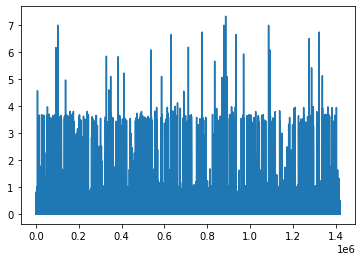

In [77]:
plt.plot(dists[:, 0])

In [106]:
(dists[:, 0] > threshold).sum()  # level의 개수

tensor(1002)

In [107]:
df = {"id": list(range(1000000, 2418915 + 1)), "level": levels.tolist()}

In [108]:
df = pd.DataFrame(df)

In [109]:
df

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [110]:
df.to_csv("results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1-threshold0.5.csv", index=False)

## Threshold 변경해서 다시 시도

In [11]:
# sfeats 저장
activation = []
sfcfeats = []
with tqdm(total=len(trainer.dl_test.dataset), ncols=100, file=sys.stdout) as t:
    for _, text, otext in trainer.dl_test:
        sfcfeat = model(text.cuda(non_blocking=True))[0].cpu()
        sfcfeats.append(sfcfeat)
        t.update(len(text))

100%|██████████████████████████████████████████████████| 1418916/1418916 [1:11:04<00:00, 332.74it/s]


In [12]:
sfeats = torch.cat(activation)
sfcfeats = torch.cat(sfcfeats)

In [13]:
np.savez_compressed(
    "results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1-sfeats.npz", sfeats=sfeats, sfcfeats=sfcfeats
)

## dist값, KNN level, FC level 을 저장

여기서 reload

In [4]:
data = np.load("results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1-sfeats.npz")
sfeats=data["sfeats"]
sfcfeats=data['sfcfeats']

In [5]:
sfeats = torch.from_numpy(sfeats)
sfcfeats=torch.from_numpy(sfcfeats)

In [7]:
sfeats.shape

torch.Size([1418916, 768])

In [14]:
sfeats_ = sfeats.cuda()

In [9]:
deck = torch.load("results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1-deck.pth")

In [15]:
deck["feat_"] = deck["feat"].cuda()

In [11]:
deck.keys()

dict_keys(['feat', 'tlevel', 'fclevel', 'feat_'])

In [ ]:
# dist를 구함
dists, fclevels, tlevels = [], [], []
with tqdm(total=len(trainer.dl_test.dataset), ncols=100, file=sys.stdout) as t:
    for sfeat_, sfcfeat in zip(sfeats_, sfcfeats):
        dist_, index_ = get_dist(deck["feat_"], sfeat_, 8)
        dists.append(dist_.cpu())
        tlevels.append(deck["tlevel"][index_[0]].item())
        fclevels.append(sfcfeat)

        t.update()

 28%|██████████████▍                                    | 402024/1418916 [54:11<2:15:06, 125.45it/s]